#### Libraries/Setup

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random

# Plot style to use for matplotlib
plt.style.use('fivethirtyeight')

# Alter display of output (From columns to rows)
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
    overflow: auto;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [2]:
# Build a function that converts all dates in a dataframe to pandas dates
def date_conv(s):
    dates = {date: pd.to_datetime(date) for date in s.unique()}
    return s.map(dates)

In [3]:
# Build a function that loads ticketing data - any number of files - 
#   and returns a bound dataframe
def data_load(list_of_data_file_names):
    # Create empty data frame
    df = pd.DataFrame()
    # Map data to add path to file name
    data = list(map(lambda x: '/data/ticketing/' + x + '.csv', list_of_data_file_names))
    # Loop list and concat each file with empty df
    for i in data:
        df_to_bind = pd.read_csv(i,skiprows=3)
        df = pd.concat([df,df_to_bind])
    # Convert dates and format some rows
    df['perf_dt'] = date_conv(df['perf_dt'])
    df = df.dropna(subset=['summary_cust_id'])
    df = df[(df['paid_amt'] > 5) & df['summary_cust_id'] != 0]
    # Represent perf dt by FY
    df.loc[df.perf_dt < datetime(2016,7,1), 'fy'] = 16
    df.loc[(df.perf_dt < datetime(2017,7,1)) & (df.perf_dt >= datetime(2016,7,1)), 'fy'] = 17
    df.loc[(df.perf_dt < datetime(2018,7,1)) & (df.perf_dt >= datetime(2017,7,1)), 'fy'] = 18
    df.loc[(df.perf_dt < datetime(2019,7,1)) & (df.perf_dt >= datetime(2018,7,1)), 'fy'] = 19
    # Select columns to use
    df = df[['summary_cust_id',
             'season_desc',
             'price_type_group',
             'paid_amt',
             'perf_dt',
             'fy']]
    return(df)

#### Load data 

In [4]:
# load data into the df variable. 
#   Parse df into single_purchasers, subscription_purchasers, and all purchasers.
data = ['Clx19']
df = data_load(data)
single_purchasers = df[(df['price_type_group'] != 'Subscription') \
                       & (df['price_type_group'] != 'Flex')]
subscription_purchasers = df[(df['price_type_group'] != 'Single ') \
                             & (df['price_type_group'] != 'Discount')]
all_purchasers = df

In [5]:
# Structure of all_purchasers dataframe
#   This is identical in form to subscription_purchasers and single_purchasers
all_purchasers.head()

,summary_cust_id,season_desc,price_type_group,paid_amt,perf_dt,fy
315,13241.0,PS 18-19 Classics,Subscription,25.00,2018-09-27 20:00:00,19.0
316,16202.0,PS 18-19 Classics,Single,92.50,2018-09-27 20:00:00,19.0
317,18577.0,PS 18-19 Classics,Subscription,164.25,2018-09-27 20:00:00,19.0
318,18577.0,PS 18-19 Classics,Subscription,164.25,2018-09-27 20:00:00,19.0
319,18631.0,PS 18-19 Classics,Subscription,98.50,2018-09-27 20:00:00,19.0


#### Format the dataframes

In [6]:
# Average paid amount by individual performance date.
# Count the total performances that tickets are purchased for
# Count the total number of performances purchased and average ticket price
# View the structure of the new dataframes

df_list = [all_purchasers,single_purchasers,subscription_purchasers]

def formatting_dfs(df_list):
    empty_list = []
    
    for i in df_list:
        # first get mean by id and perf dt. this will convert from looking at number of tickets
        #      purchased to number of performances
        i = i.groupby(['summary_cust_id','perf_dt'], as_index=False)['paid_amt']\
             .mean()
        # average and count the paid amount for each individual customer id
        i = i.groupby(['summary_cust_id'], as_index=False)['paid_amt']\
             .agg(['mean','count'])
        # append the empty list and return it
        empty_list.append(i)
    
    df_dict = {'all':empty_list[0],
              'singles':empty_list[1],
              'subs':empty_list[2]}
    return df_dict

dfs = formatting_dfs(df_list)

# View the new df structure for the 'all' dataframe in the dfs dictionary
dfs['all'].head()

,mean,count
summary_cust_id,,
10161.0,96.500000,6
10327.0,30.000000,4
11900.0,79.500000,1
13241.0,41.134615,13
16202.0,92.500000,1


#### Summary statistics

In [7]:
# the dataframe for all
display(dfs['all'].describe())
display(dfs['singles'].describe())
display(dfs['subs'].describe())

# Displays the summary statistics for the dataframes in order of: All, Singles, and Subscribers
# The mean column represents average ticket price
# The count column represents frequence of performances

,mean,count
count,5078.000000,5078.000000
mean,63.471254,3.419456
std,40.294258,3.590869
min,10.000000,1.000000
25%,30.000000,1.000000
50%,55.000000,1.000000
75%,93.000000,5.000000
max,221.000000,19.000000


,mean,count
count,3214.000000,3214.000000
mean,66.702466,1.285003
std,43.389615,0.858660
min,10.000000,1.000000
25%,30.000000,1.000000
50%,54.000000,1.000000
75%,96.000000,1.000000
max,221.000000,11.000000


,mean,count
count,2147.000000,2147.00000
mean,58.823021,6.24313
std,34.409483,3.84770
min,16.583333,1.00000
25%,33.000000,3.00000
50%,55.000000,6.00000
75%,75.000000,11.00000
max,196.000000,19.00000


### Box plots
Visualize box plots of variables to determine structure and outliers

In [8]:
# Create the function
def boxplot_for_multi_data(data_list,plot_title):
    fig, ax = plt.subplots()
    fig.set_size_inches(15,10)
    ax.set_title(plot_title)
    ax.boxplot(data_list)
    ax.set_xticklabels(['all','singles','subs'], fontsize = 16)
    plt.show()

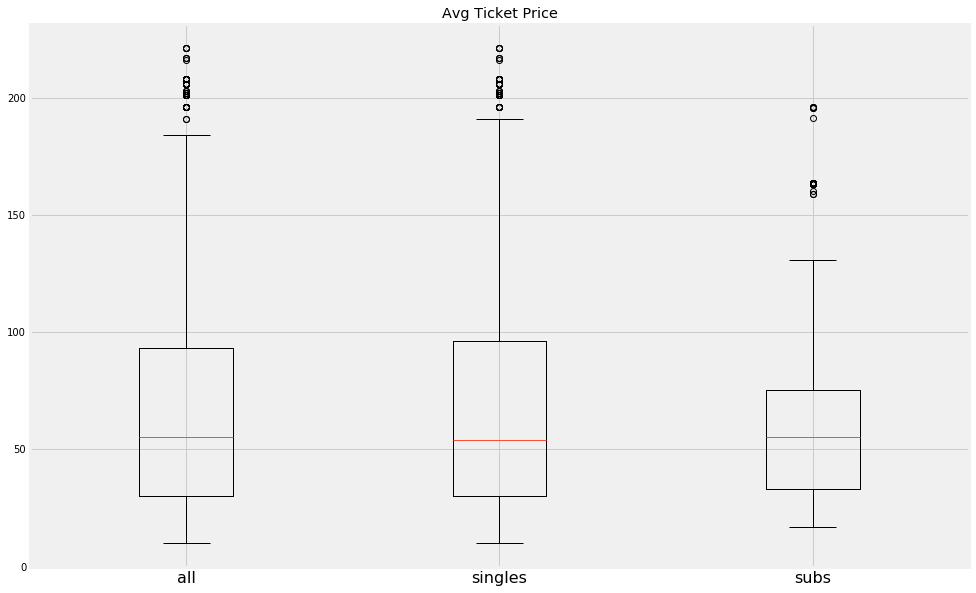

In [9]:
# Boxplot for average ticket price
avg_price_data = [dfs['all']['mean'], dfs['singles']['mean'], dfs['subs']['mean']]
boxplot_for_multi_data(avg_price_data,'Avg Ticket Price')

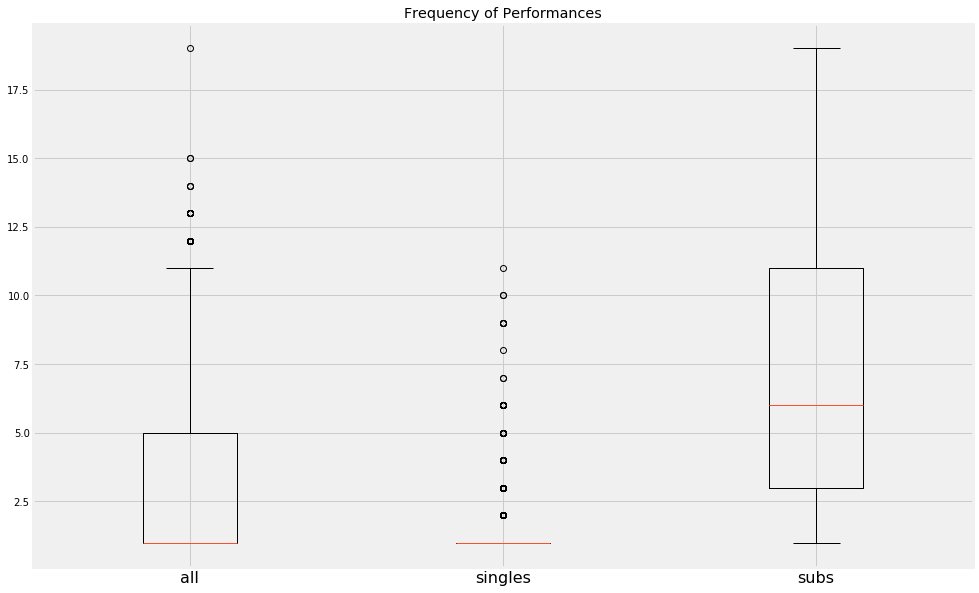

In [10]:
# Boxplot for frequency of performances
freq_data = [dfs['all']['count'], dfs['singles']['count'], dfs['subs']['count']]
boxplot_for_multi_data(freq_data,'Frequency of Performances')

### Scatterplots 
Loop through dfs dictionary and provide scatter plot matrix analyzing relationship between avg ticket price and number of performances attended for each 

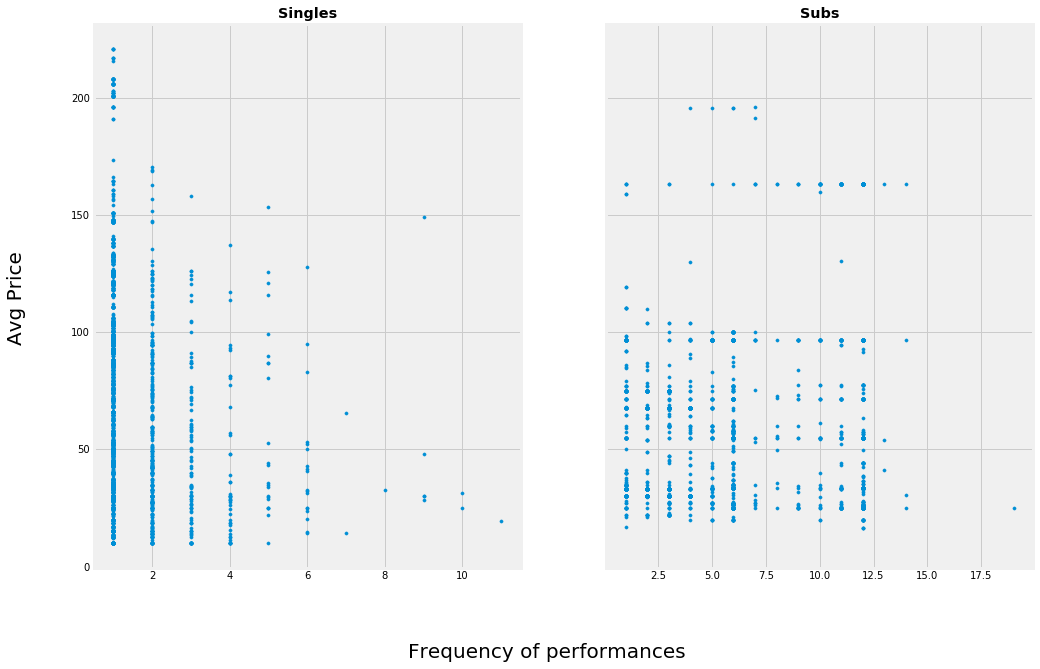

In [11]:
# Create the function
def scatterplots_single_df(ax,df,title):
    ax.scatter(df['count'],
               df['mean'],
               s = 10)
    ax.set_title(title, fontweight='bold')

# Plot the scatters
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
fig.set_size_inches(15,10)
fig.text(0, 0.5, 'Avg Price', va='center', rotation='vertical', fontsize=20)
fig.text(0.5, 0, 'Frequency of performances', ha='center', fontsize=20)
scatterplots_single_df(ax1,dfs['singles'],'Singles')
scatterplots_single_df(ax2,dfs['subs'],'Subs')
plt.show()


## Transform data if desired

In [12]:
for name,df in dfs.items():
    df['mean_trans'] = np.log(df['mean'])
    df['count_trans'] = df['count']

dfs['all'][['mean_trans','count_trans']].head()

,mean_trans,count_trans
summary_cust_id,,
10161.0,4.569543,6
10327.0,3.401197,4
11900.0,4.375757,1
13241.0,3.716850,13
16202.0,4.527209,1


Utilize k-means++ to plot wcss and utilize elbow method to determine optimal number of clusters for each <br>
#### Plot each elbow

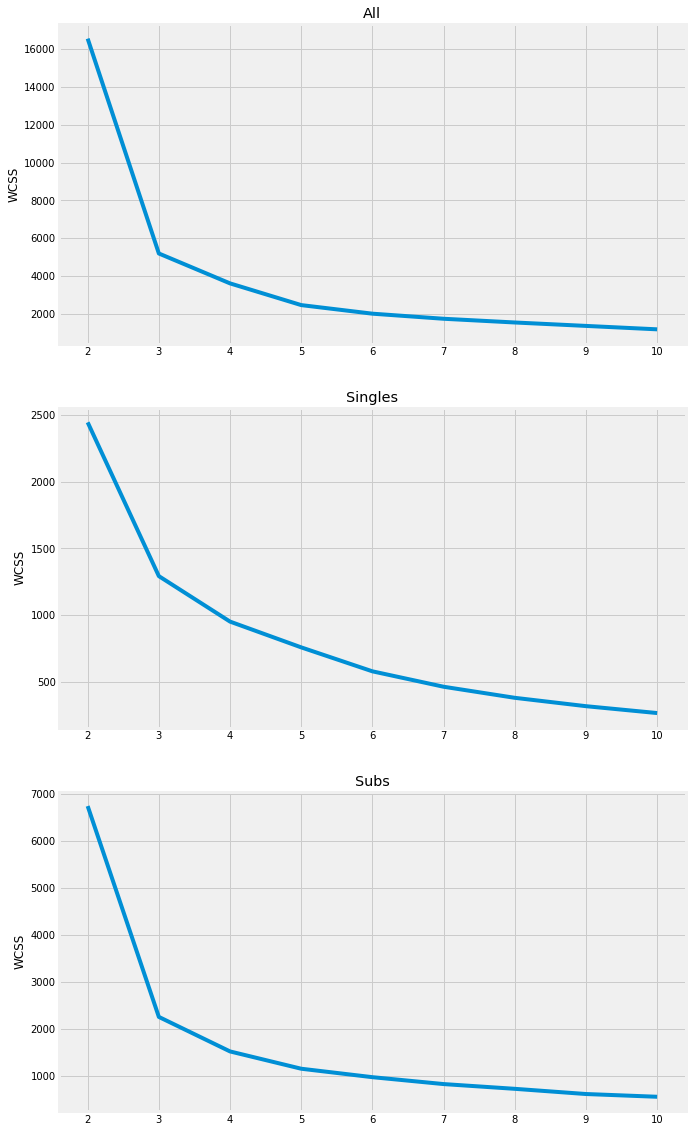

In [13]:
# Create the function
def elbow_plots(ax,df,title):
    wcss = []   
    # plot up to 9 points, range(2,11) takes on nums 2-10
    for i in range(2,11):
        kmeans = KMeans(n_clusters = i, init = 'k-means++')
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
    ax.plot(range(2,11), wcss)
    ax.set_title(title)
    ax.set_ylabel('WCSS')

# Plot the elbows
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)
fig.set_size_inches(10,20)
elbow_plots(ax1,dfs['all'][['mean_trans','count_trans']],'All')
elbow_plots(ax2,dfs['singles'][['mean_trans','count_trans']],'Singles')
elbow_plots(ax3,dfs['subs'][['mean_trans','count_trans']],'Subs')
plt.show()

Observationally speaking, the optimal number of clusters is 4 in all cases. <br>
Apply kmeans to each individual dataset and add to new column named cluster

#### Visualize the clusters

In [14]:
def cluster_plot(df,name,number_of_clusters):
    fig = plt.figure()
    fig.set_size_inches(15,10)
    ax1 = fig.add_subplot(111)
    # apply number of clusters to kmeans algorithm
    kmeans = KMeans(n_clusters = number_of_clusters, 
                    init = 'k-means++')

    # predict which cluster each customer ID belongs to
    df['cluster'] = kmeans.fit_predict(df[['mean_trans','count_trans']])
    
    # list of colors to use at random for selected cluster
    colors = ['red','green','blue','yellow','gray','orange','purple','magenta']
    
    for i in range(1,number_of_clusters + 1):
        color_index = random.randint(0,len(colors)-1)
        ax1.scatter(df[df['cluster'] == i - 1]['count_trans'],
                    df[df['cluster'] == i - 1]['mean_trans'],
                    s = 10, c = colors[color_index], label = 'Cluster ' + str(i))
        colors.pop(color_index)
        
    plt.title('Clusters - ' + name)
    plt.xlabel('Frequency')
    plt.ylabel('Avg Ticket Price')
    plt.legend()
    plt.show()

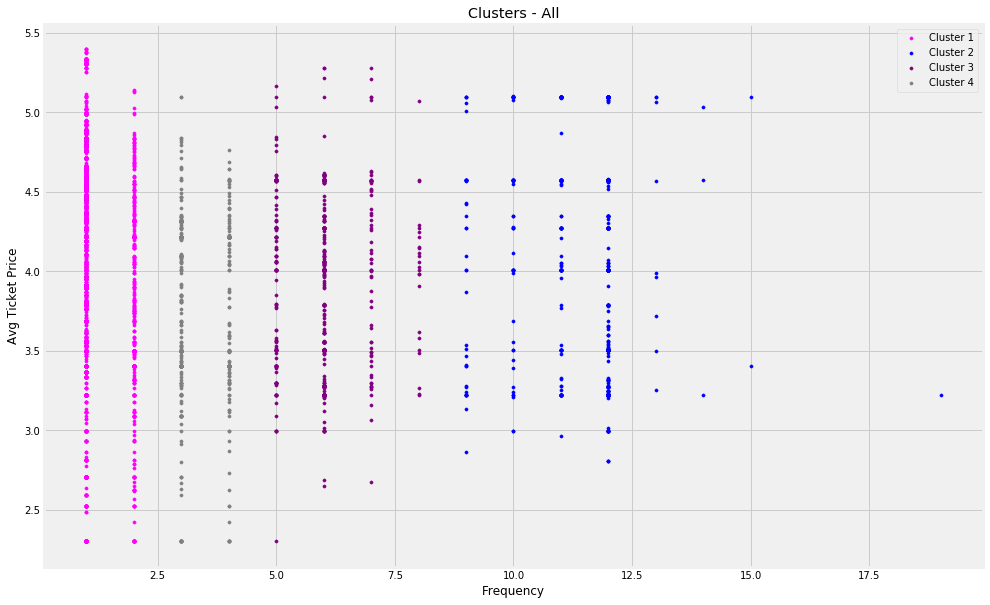

In [15]:
cluster_plot(dfs['all'],'All',4)